In [19]:
import json
import logging
from pathlib import Path
from copy import deepcopy

import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import pandas as pd

In [20]:


# ---------------------------
# LOGGING & CONFIG
# ---------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [21]:


# CONFIGURATION
COCO_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json")
IMAGES_DIR       = Path("../data/rotation/batches/rotation_20250721_01/images/default/")
PRED_JSON        = Path("../data/rotation/batches/rotation_20250721_01/instances_predicted.json")
ATTR_JSON       = Path("../data/rotation/batches/rotation_20250721_01/instances_updated.json")
CHECKPOINT_PATH = Path("checkpoints/best_model.pth")


In [22]:

CLASS_NAMES = [0, 180, 270, 90 ]
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_SIZE = 300

TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [23]:
# ---------------------------
# I/O
# ---------------------------
def load_coco(path: Path) -> dict:
    logger.info(f"Loading COCO from {path}")
    return json.loads(path.read_text(encoding="utf-8"))

def save_coco(coco: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    logger.info(f"Writing COCO to {path}")
    path.write_text(json.dumps(coco, ensure_ascii=False, indent=2), encoding="utf-8")

# ---------------------------
# MODEL
# ---------------------------
def load_model(ckpt_path: Path) -> nn.Module:
    logger.info(f"Loading model from {ckpt_path}")
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    ckpt = torch.load(str(ckpt_path), map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    return model.to(DEVICE).eval()

In [24]:
# ---------------------------
# HELPERS
# ---------------------------
def extract_current_rotation(ann: dict) -> float:
    bb = ann.get("bbox", [])
    if len(bb) == 5:
        return float(bb[4])
    attrs = ann.get("attributes", {})
    return float(attrs.get("rotation", 0.0))

def crop_box(img: np.ndarray, x, y, w, h) -> np.ndarray:
    x1, y1 = max(0, int(round(x))), max(0, int(round(y)))
    x2 = min(img.shape[1], int(round(x + w)))
    y2 = min(img.shape[0], int(round(y + h)))
    return img[y1:y2, x1:x2]

def crop_rotated_preserve(img: np.ndarray, cx, cy, w, h, angle: float) -> np.ndarray:
    # compute AABB of the rotated rectangle
    theta = np.deg2rad(angle)
    w2 = abs(w*np.cos(theta)) + abs(h*np.sin(theta))
    h2 = abs(w*np.sin(theta)) + abs(h*np.cos(theta))
    x1 = int(round(cx - w2/2))
    y1 = int(round(cy - h2/2))
    x2 = int(round(cx + w2/2))
    y2 = int(round(cy + h2/2))
    # clamp
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
    return img[y1:y2, x1:x2]

In [25]:
def predict_angle(model: nn.Module, patch: np.ndarray) -> float:
    rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    tensor = TRANSFORM(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(tensor)
        idx = torch.argmax(logits, dim=1).item()
    return float(CLASS_NAMES[idx])

In [26]:
def debug_annotation(ann_id, img_id, fname, orig_rot, pred_rot, bbox, full_img):
    x, y, w, h = bbox
    cx, cy = x + w/2, y + h/2
    # choose crop that preserves full object
    patch = crop_rotated_preserve(full_img, cx, cy, w, h, orig_rot)
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    full_rgb  = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    print(f"\n▶ Ann {ann_id} on img {img_id} ({fname})")
    print(f"  orig_rot: {orig_rot}°, pred_rot: {pred_rot}°")
    print(f"  bbox: {bbox}")

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
    ax1.imshow(patch_rgb); ax1.axis("off")
    ax1.set_title(f"Rotated crop ({patch.shape[1]}×{patch.shape[0]})")
    ax2.imshow(full_rgb); ax2.axis("off")
    # overlay both:
    ax2.add_patch(Rectangle((x, y), w, h,
                            edgecolor="orange", linestyle="--", fill=False))
    obb = Rectangle((cx-w/2, cy-h/2), w, h,
                    edgecolor="red", fill=False)
    # draw rotated CW by orig_rot → rotate CCW by -orig_rot
    obb.set_transform(Affine2D().rotate_deg_around(cx, cy, -orig_rot) + ax2.transData)
    ax2.add_patch(obb)
    ax2.scatter([x],[y], color="blue", s=5)
    ax2.scatter([cx],[cy], color="lime", s=5)
    ax2.set_title("Full image w/ OBB")
    plt.show()


INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json


INFO:__main__:Loading model from checkpoints/best_model.pth



▶ Ann 47 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [2596.23, 91.32, 16.97, 27.78]


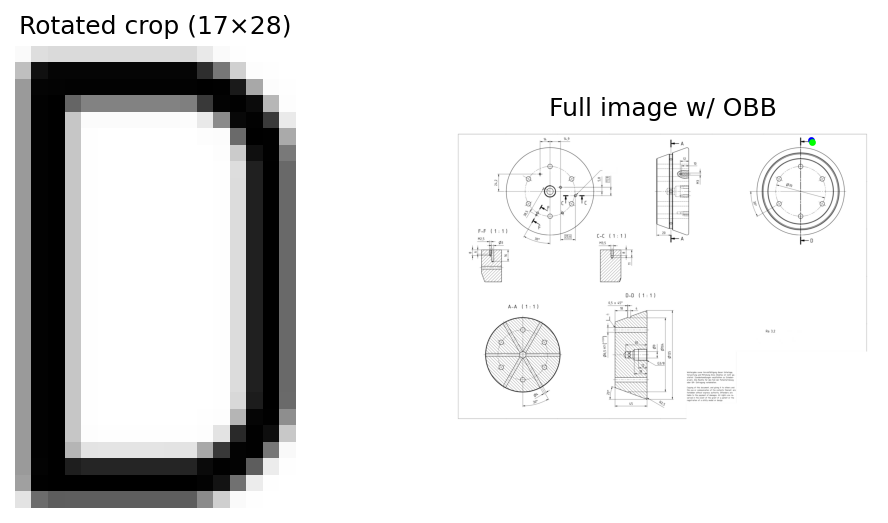

INFO:__main__:Ann 49: 0.11° → 0.0°



▶ Ann 49 on img 2 (7443.png)
  orig_rot: 0.11°, pred_rot: 0.0°
  bbox: [823.99, 780.24, 41.31, 22.46]


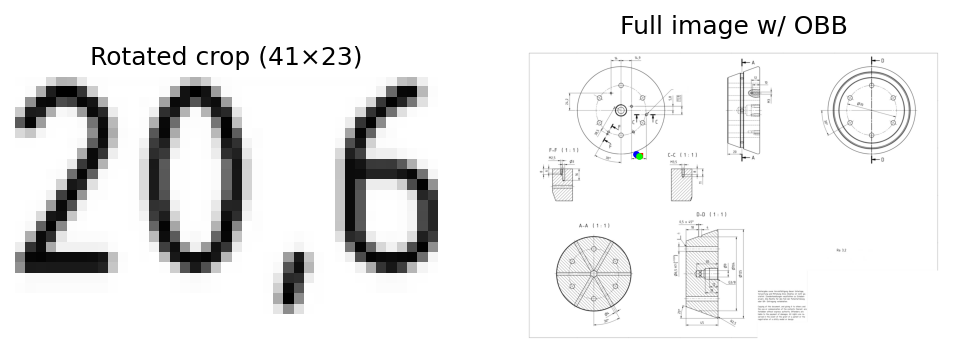


▶ Ann 50 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [412.5, 1280.62, 217.2, 33.28]


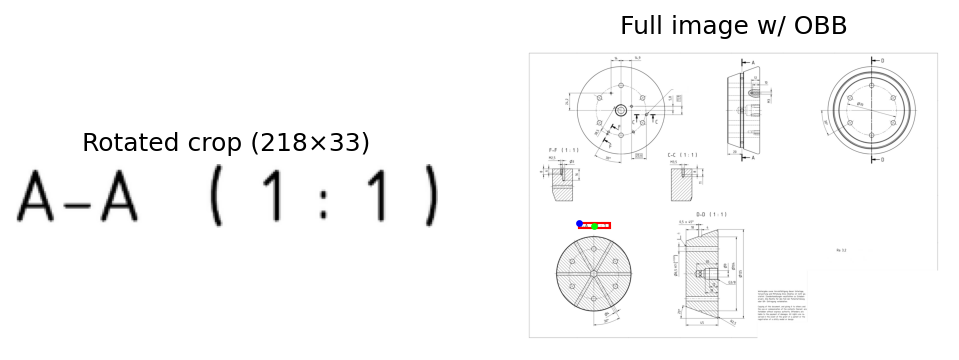

INFO:__main__:Ann 51: 270.0° → 0.0°



▶ Ann 51 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [385.15, 919.35, 19.0, 18.9]


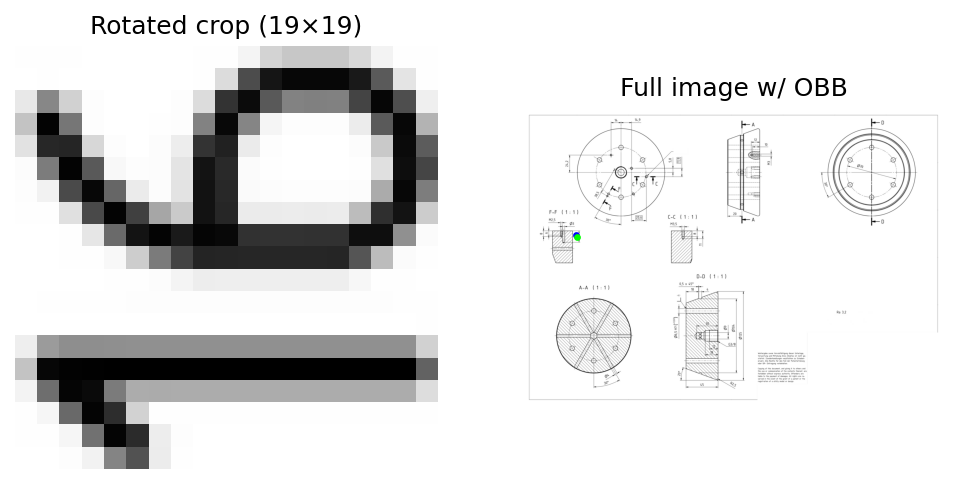


▶ Ann 52 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [129.2, 903.2, 18.6, 10.4]


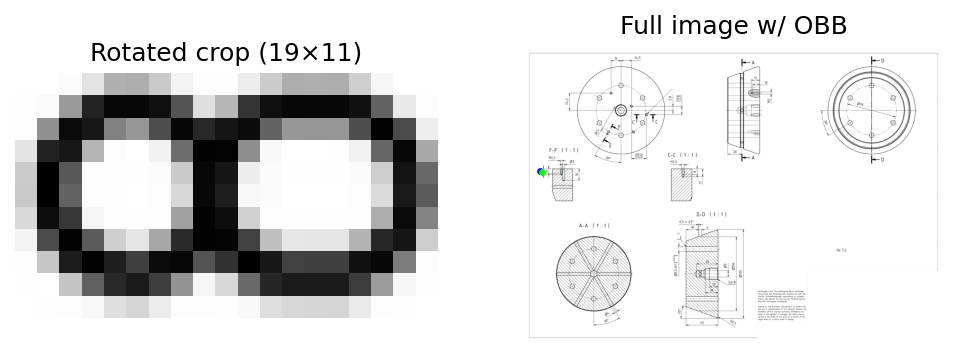

INFO:__main__:Ann 53: 270.0° → 0.0°



▶ Ann 53 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [170.95, 894.05, 10.2, 18.1]


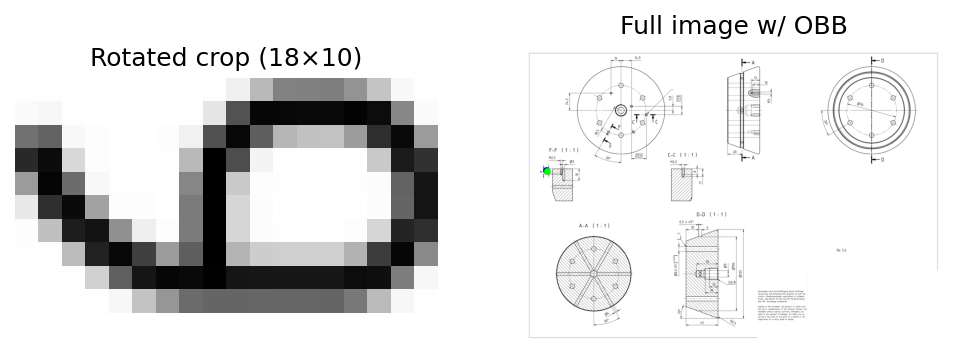


▶ Ann 54 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [344.6, 821.8, 30.3, 26.4]


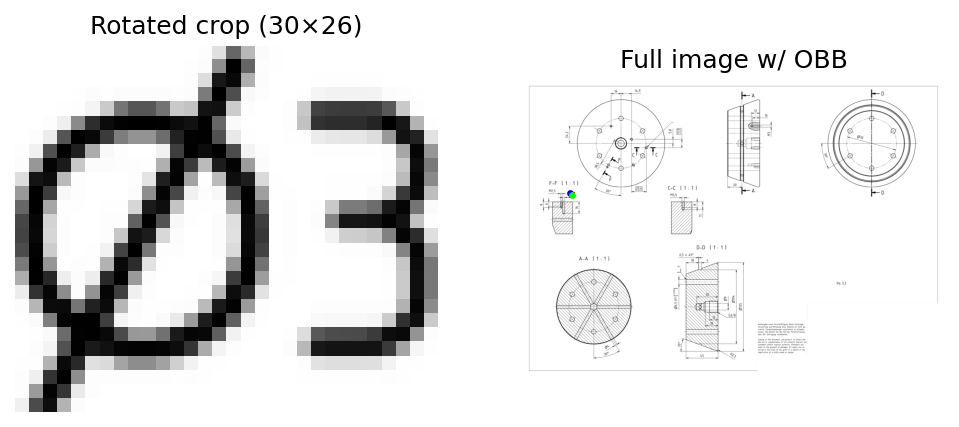


▶ Ann 56 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [195.6, 798.3, 44.9, 22.0]


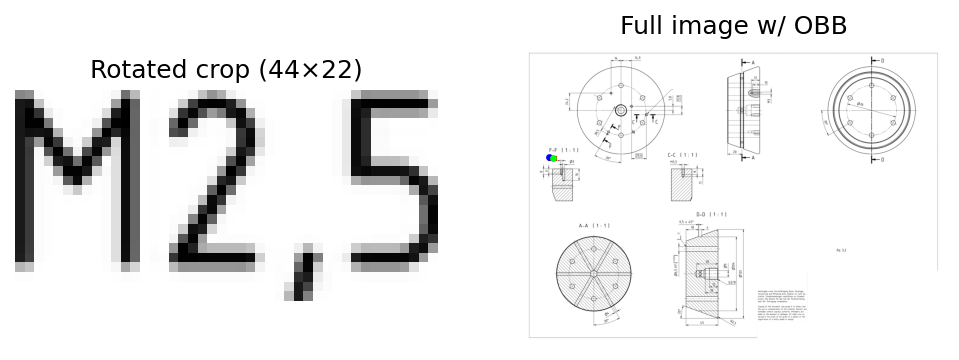

INFO:__main__:Ann 57: 0.53° → 0.0°



▶ Ann 57 on img 2 (7443.png)
  orig_rot: 0.53°, pred_rot: 0.0°
  bbox: [199.07, 734.95, 206.06, 33.25]


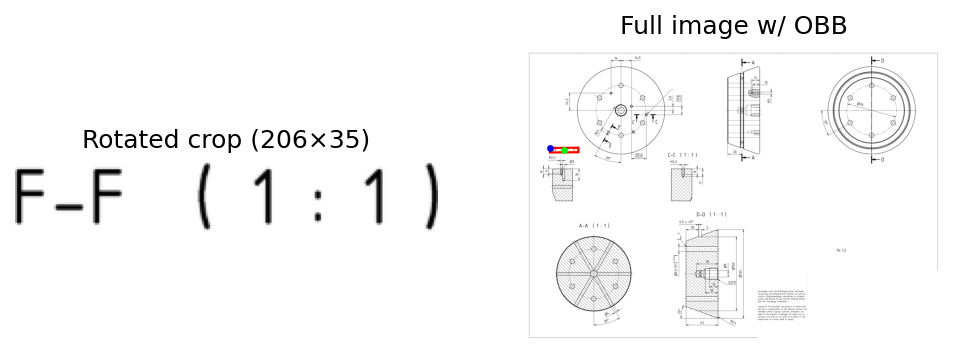

INFO:__main__:Ann 58: 270.1° → 0.0°



▶ Ann 58 on img 2 (7443.png)
  orig_rot: 270.1°, pred_rot: 0.0°
  bbox: [303.14, 391.29, 43.47, 22.53]


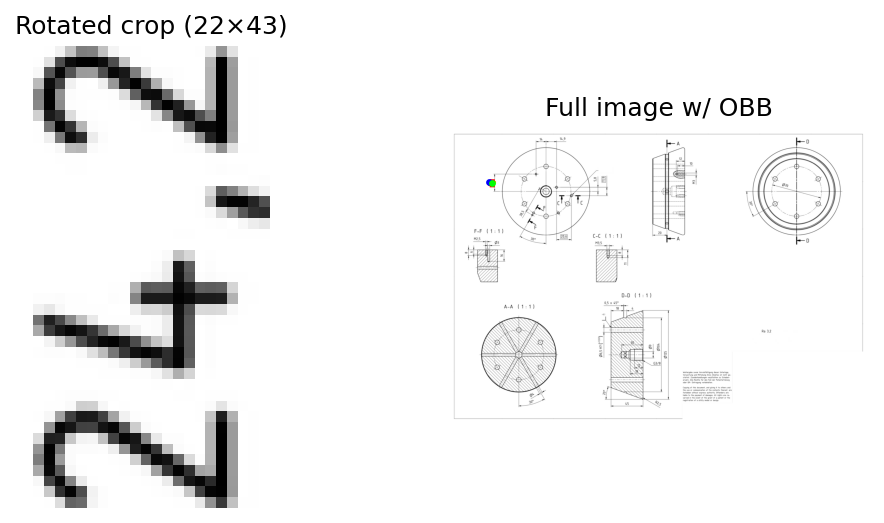

INFO:__main__:Ann 59: 278.5° → 0.0°



▶ Ann 59 on img 2 (7443.png)
  orig_rot: 278.5°, pred_rot: 0.0°
  bbox: [1118.98, 1908.26, 33.23, 19.0]


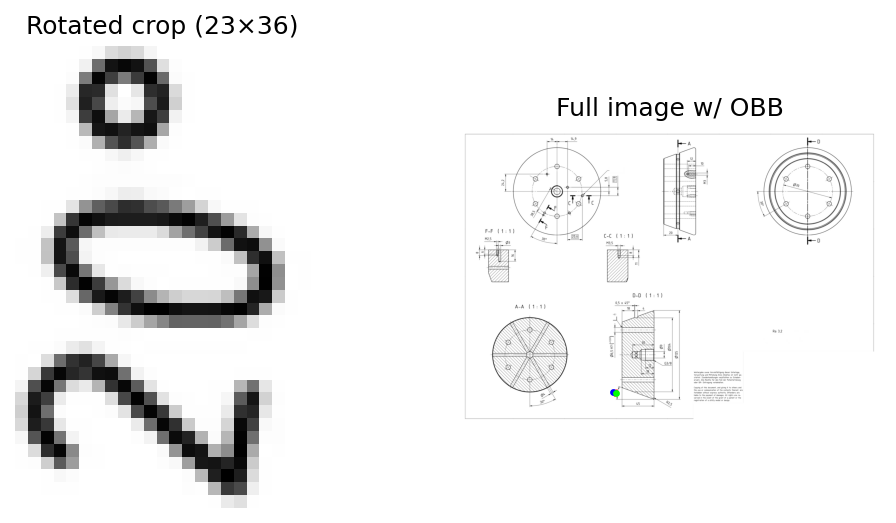

INFO:__main__:Ann 60: 270.0° → 0.0°



▶ Ann 60 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1115.43, 366.48, 33.5, 22.98]


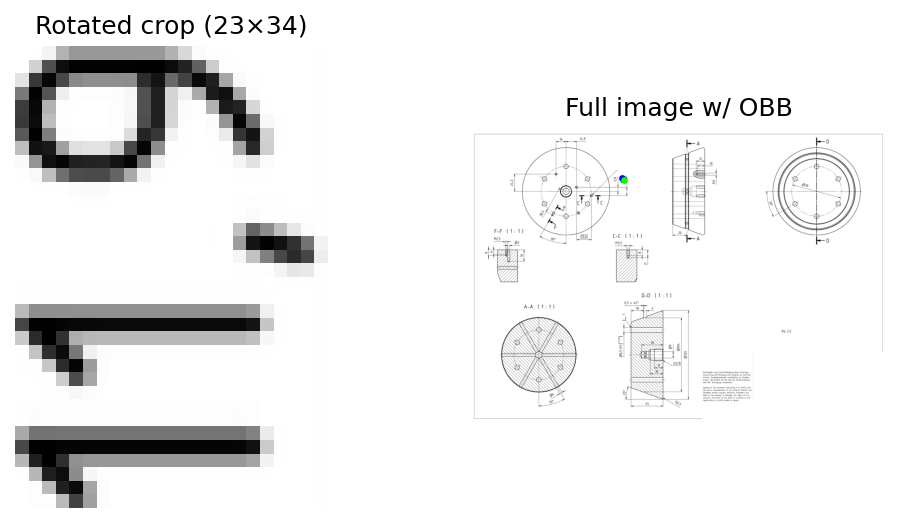

INFO:__main__:Ann 61: 270.0° → 0.0°



▶ Ann 61 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1055.64, 365.96, 29.93, 23.94]


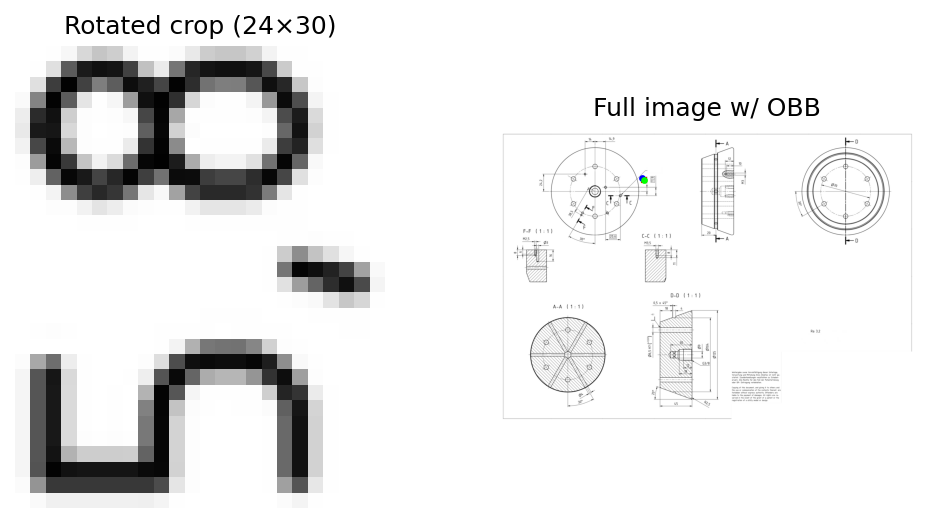


▶ Ann 64 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1090.78, 1519.52, 16.4, 41.08]


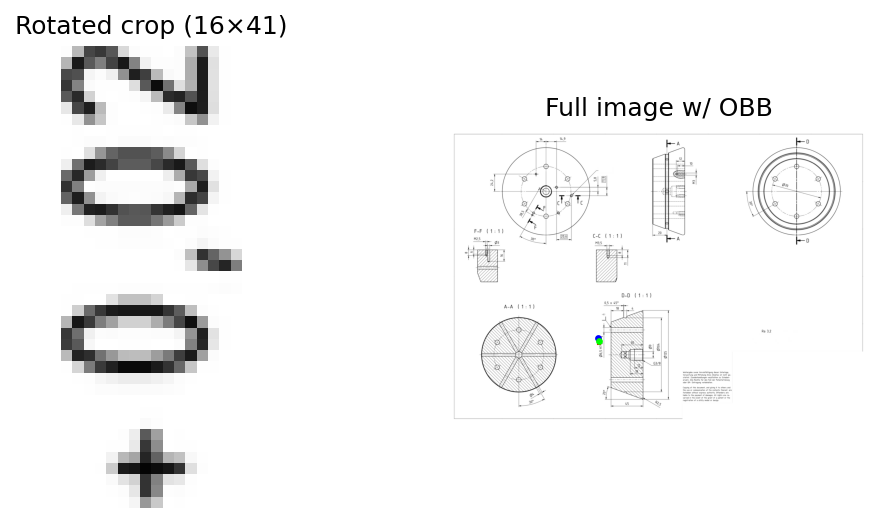


▶ Ann 65 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1659.34, 792.56, 19.71, 27.54]


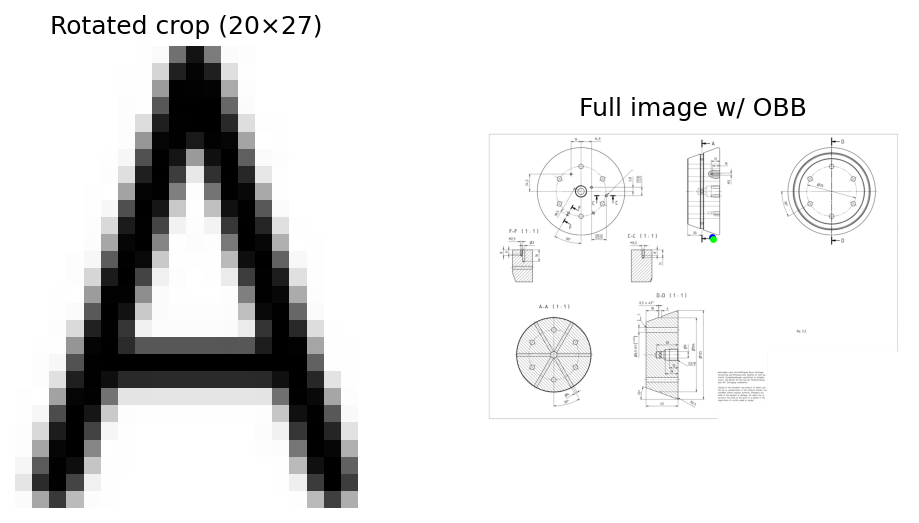


▶ Ann 66 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1137.65, 1260.62, 100.78, 23.18]


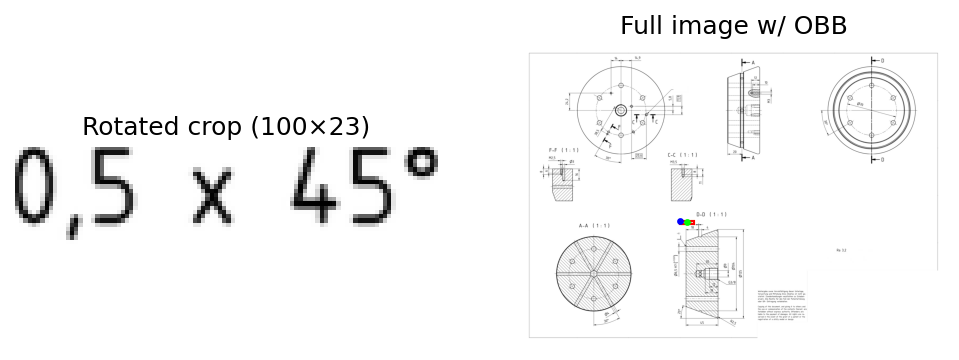


▶ Ann 67 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.64, 1949.91, 339.74, 14.66]


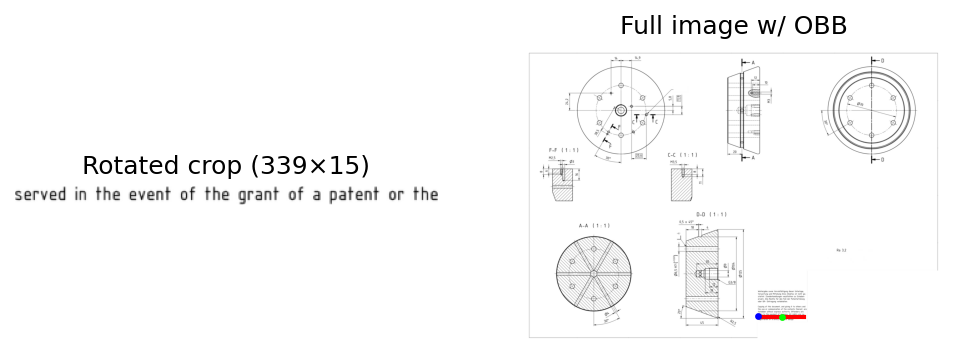


▶ Ann 68 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.69, 1931.71, 338.13, 14.71]


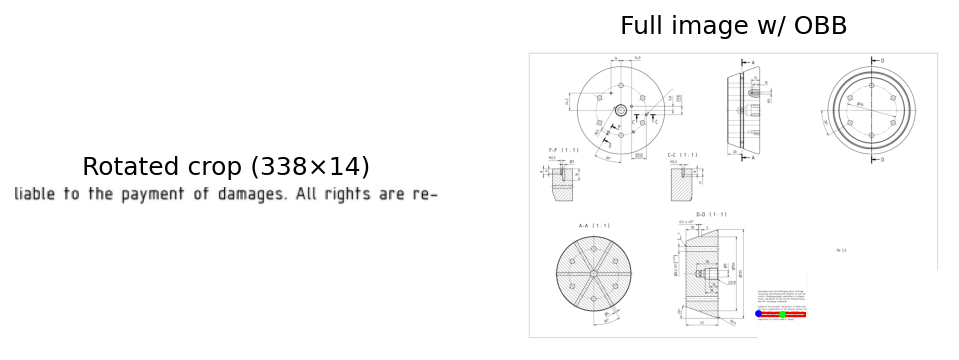


▶ Ann 69 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.53, 1913.21, 328.51, 14.18]


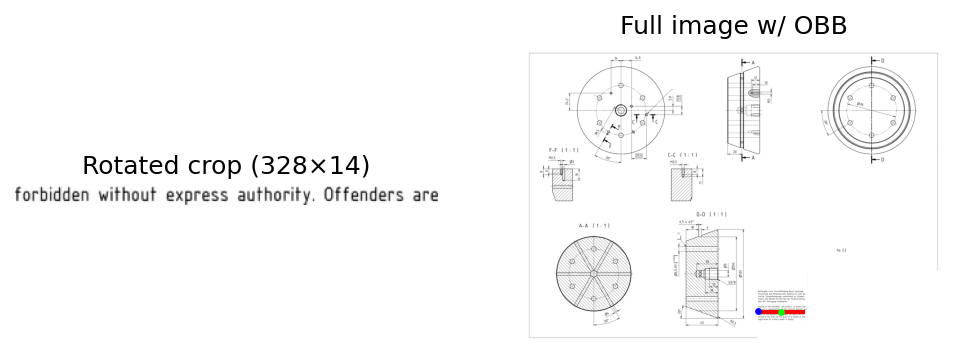


▶ Ann 70 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.67, 1895.33, 351.21, 12.46]


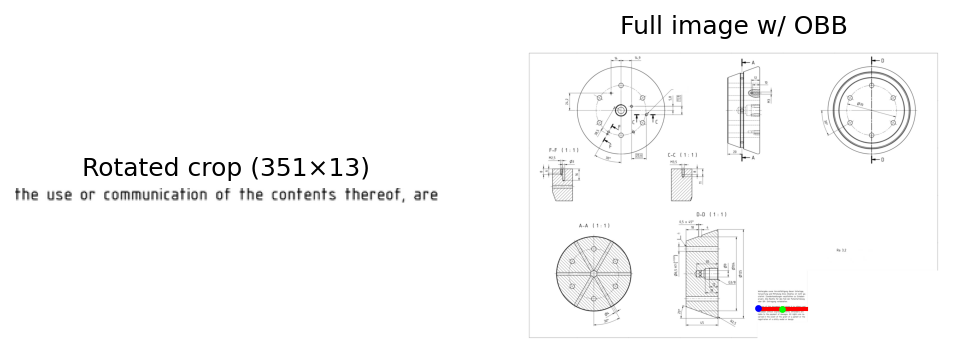

INFO:__main__:Ann 71: 270.0° → 0.0°



▶ Ann 71 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1550.4, 1632.7, 52.5, 26.7]


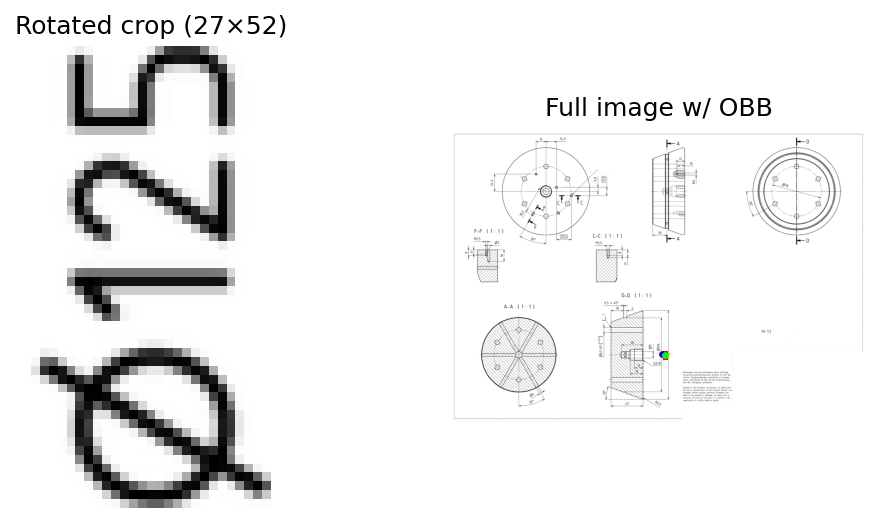


▶ Ann 74 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1753.4, 254.4, 17.9, 18.9]


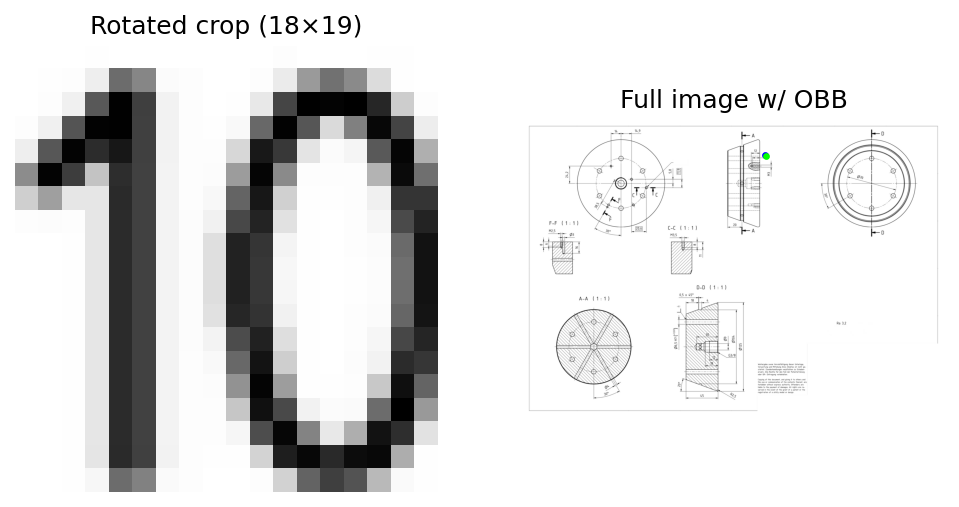

INFO:__main__:Ann 75: 270.0° → 0.0°



▶ Ann 75 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1768.44, 388.08, 26.36, 18.76]


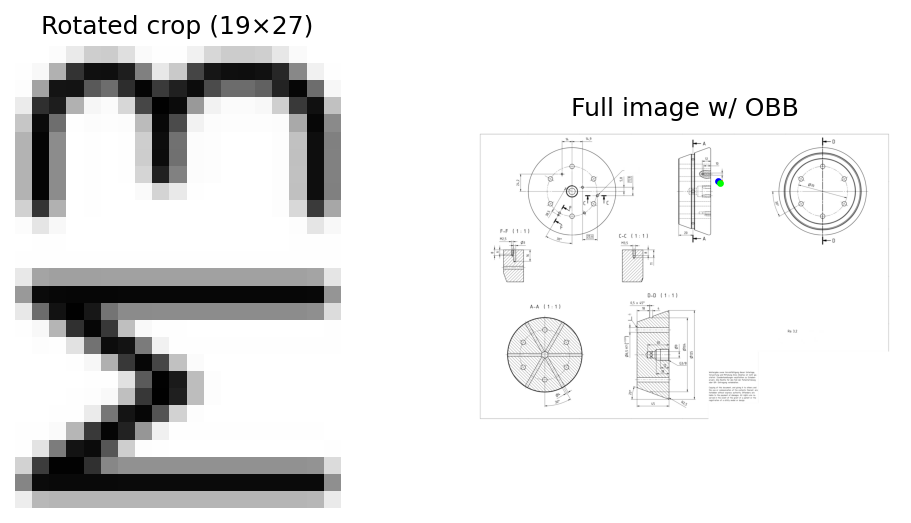


▶ Ann 76 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.3, 1766.01, 330.6, 15.19]


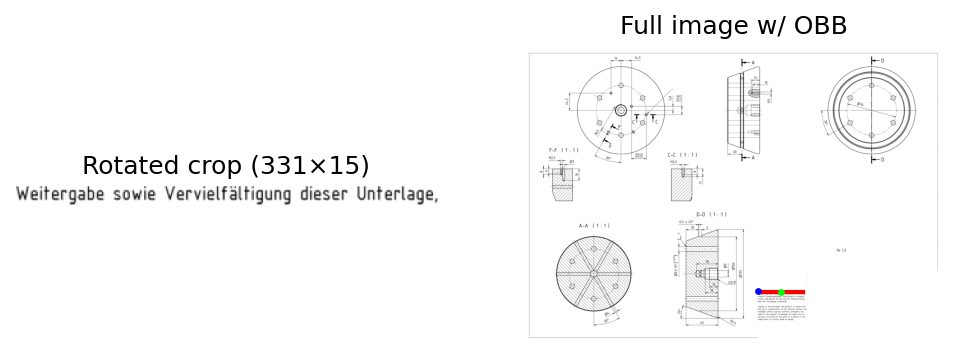


▶ Ann 77 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.9, 1968.8, 258.4, 14.3]


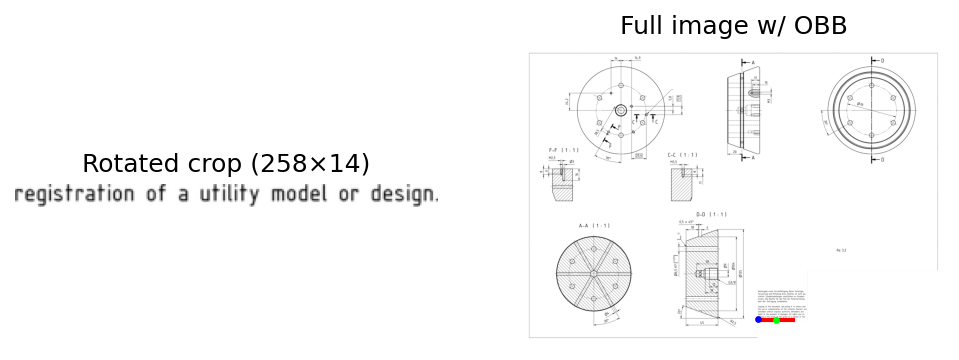


▶ Ann 78 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [668.7, 79.0, 20.5, 19.6]


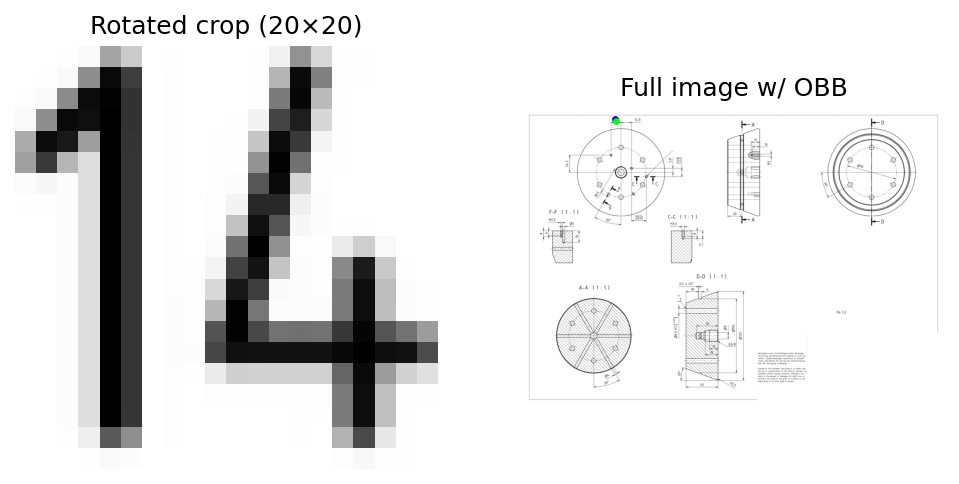


▶ Ann 79 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [631.72, 711.59, 14.4, 27.5]


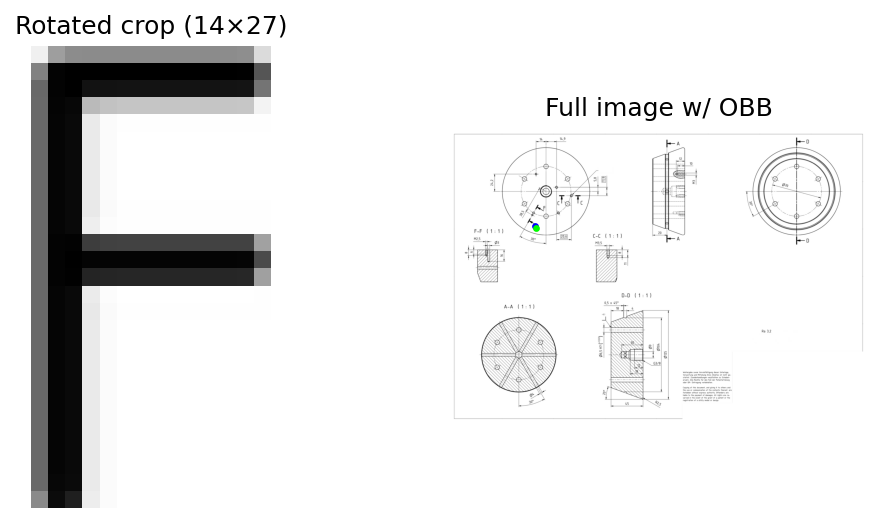


▶ Ann 80 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [696.94, 570.81, 14.6, 27.4]


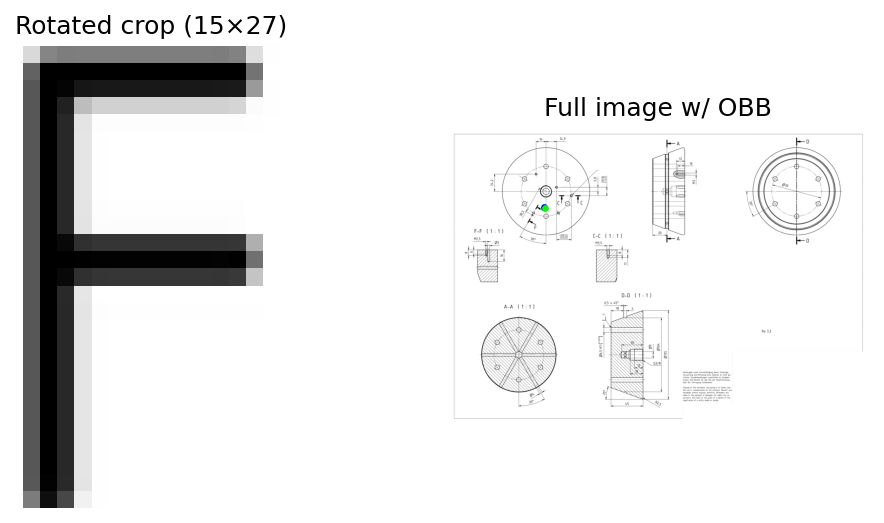


▶ Ann 82 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1375.92, 1712.92, 18.4, 19.4]


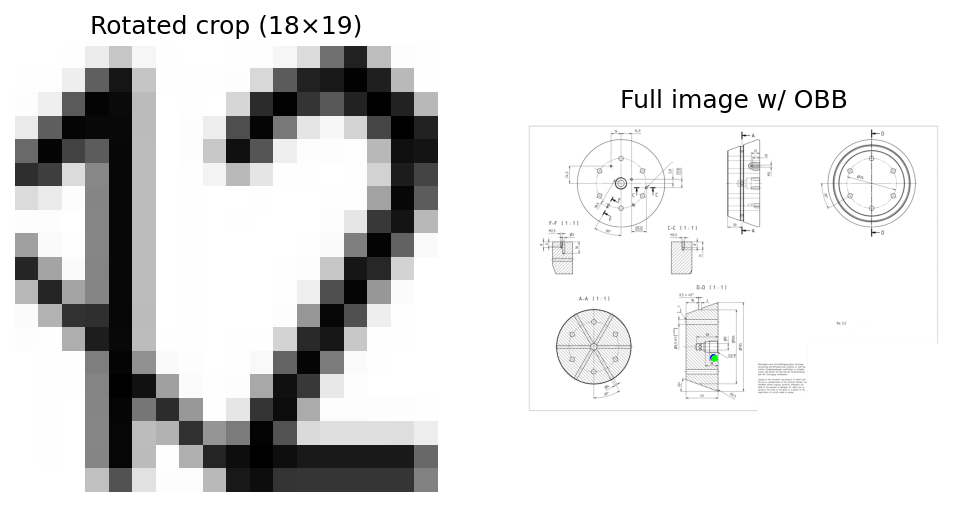


▶ Ann 83 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.73, 1785.06, 346.31, 14.24]


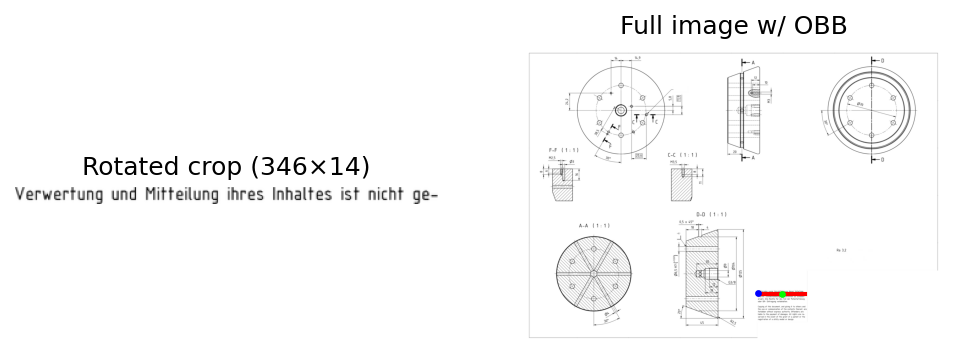


▶ Ann 84 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1704.02, 1803.07, 337.83, 14.88]


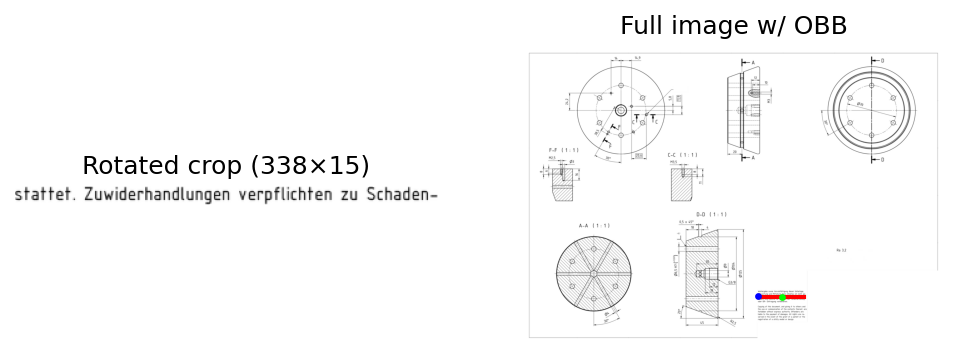


▶ Ann 85 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.85, 1821.61, 336.01, 14.26]


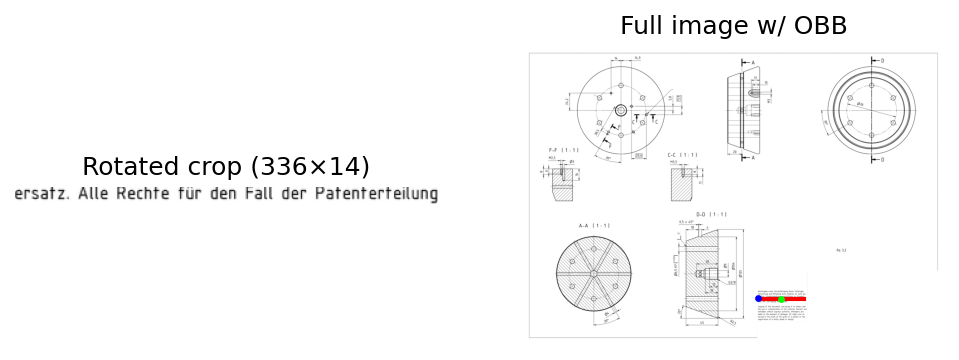


▶ Ann 86 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.99, 1839.25, 213.35, 15.16]


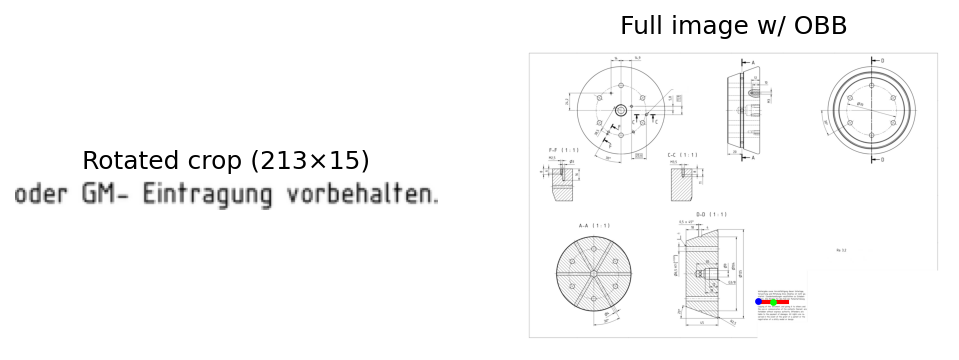


▶ Ann 87 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1703.68, 1876.59, 341.82, 14.71]


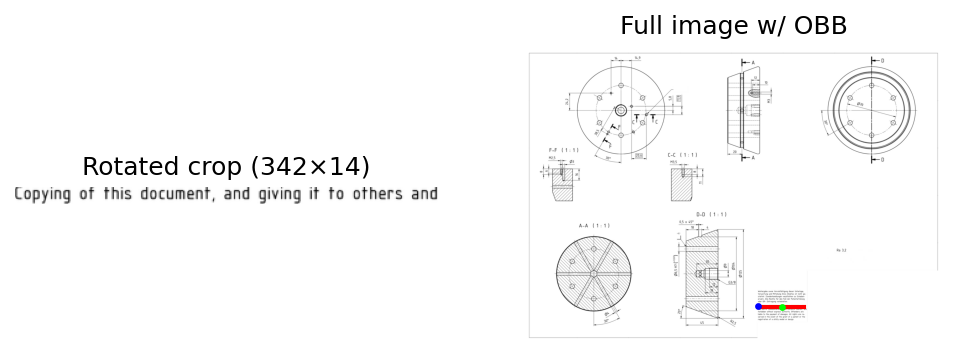

INFO:__main__:Ann 88: 0.53° → 0.0°



▶ Ann 88 on img 2 (7443.png)
  orig_rot: 0.53°, pred_rot: 0.0°
  bbox: [1055.21, 769.2, 206.2, 34.3]


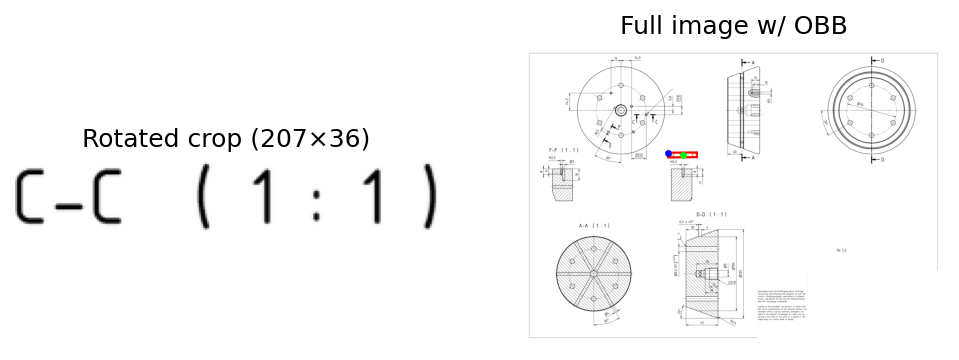


▶ Ann 89 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [814.3, 75.1, 40.4, 23.0]


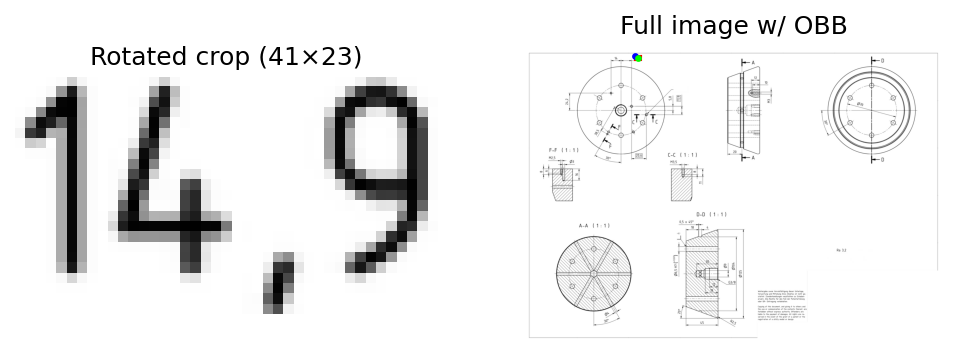

INFO:__main__:Ann 90: 0.0° → 90.0°



▶ Ann 90 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 90.0°
  bbox: [1096.68, 1577.61, 26.92, 84.89]


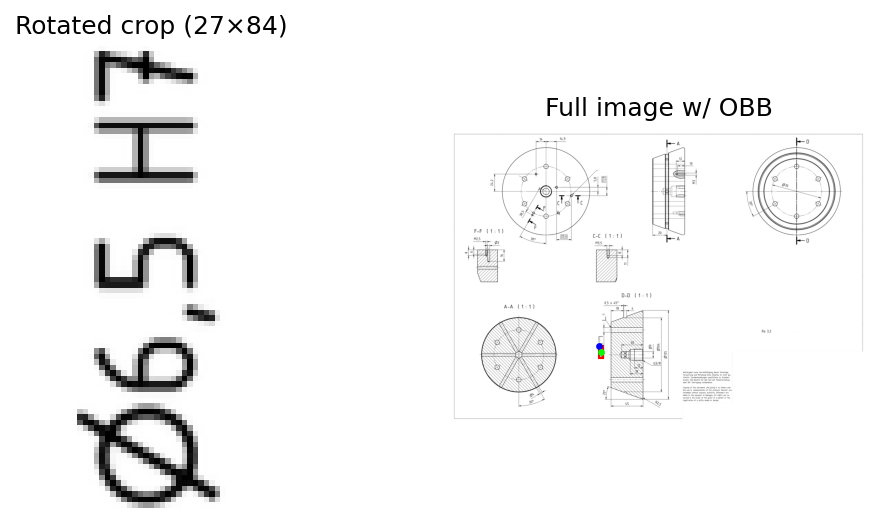


▶ Ann 91 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [965.19, 533.6, 14.61, 28.03]


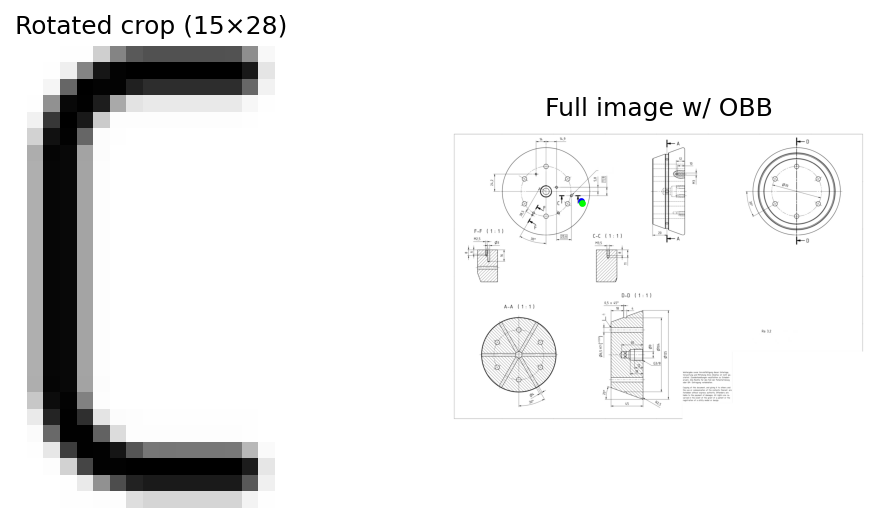


▶ Ann 92 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [797.95, 536.78, 14.45, 27.82]


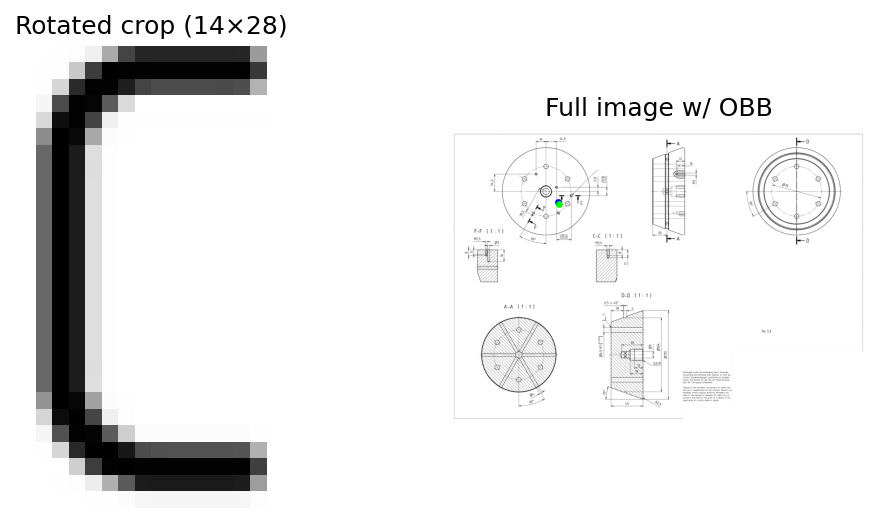

INFO:__main__:Ann 93: 90.0° → 0.0°



▶ Ann 93 on img 2 (7443.png)
  orig_rot: 90.0°, pred_rot: 0.0°
  bbox: [1451.55, 1575.25, 31.75, 27.05]


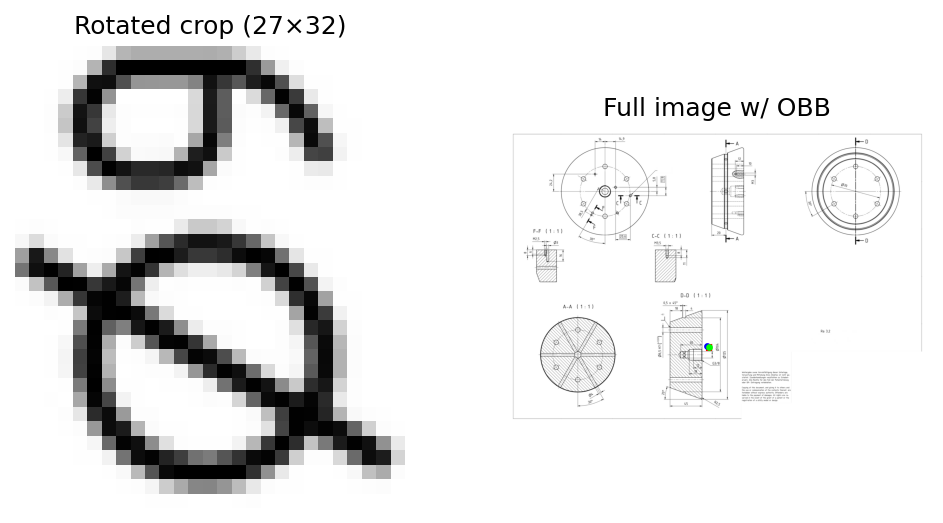

INFO:__main__:Ann 94: 0.5° → 0.0°



▶ Ann 94 on img 2 (7443.png)
  orig_rot: 0.5°, pred_rot: 0.0°
  bbox: [2273.2, 1464.4, 67.4, 23.38]


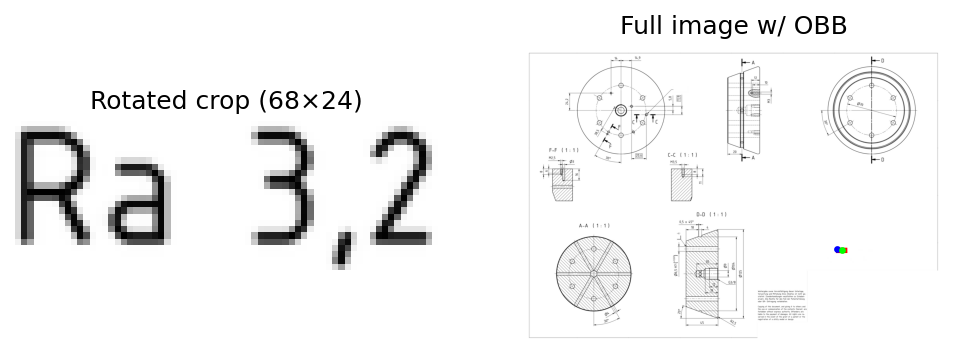


▶ Ann 95 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [2596.2, 806.3, 17.5, 28.4]


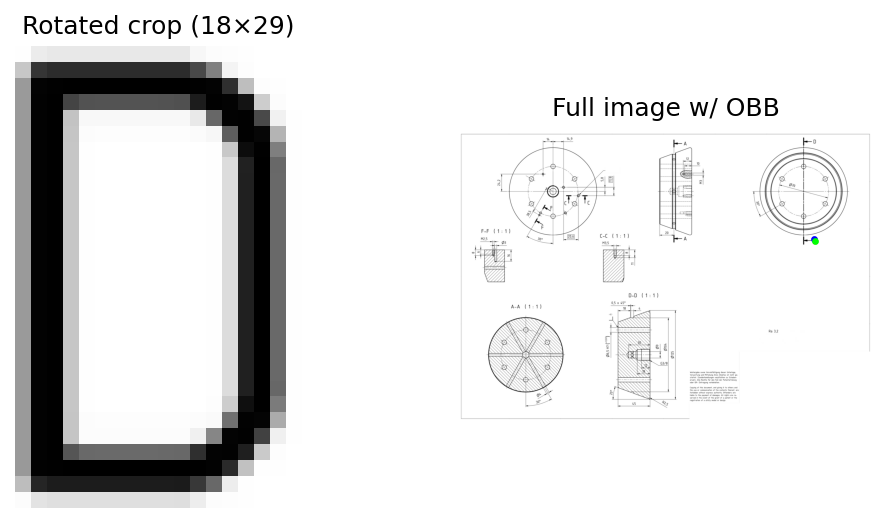

INFO:__main__:Ann 98: 270.0° → 90.0°



▶ Ann 98 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 90.0°
  bbox: [1499.6, 1577.4, 53.6, 26.8]


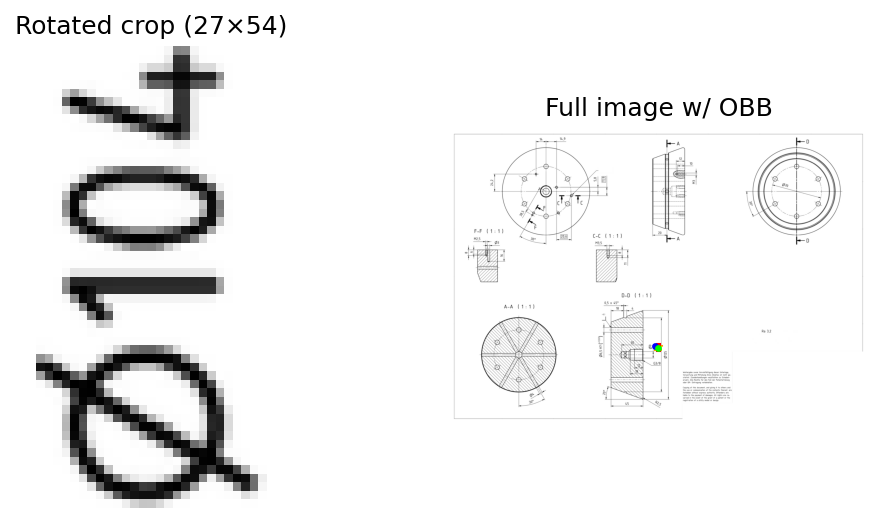


▶ Ann 99 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1659.8, 105.8, 19.2, 27.6]


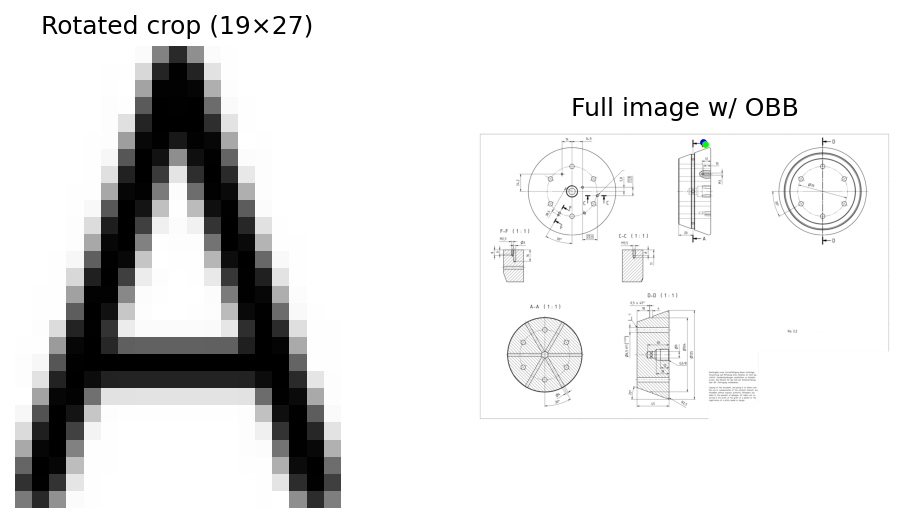


▶ Ann 100 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1221.8, 1300.5, 18.4, 19.0]


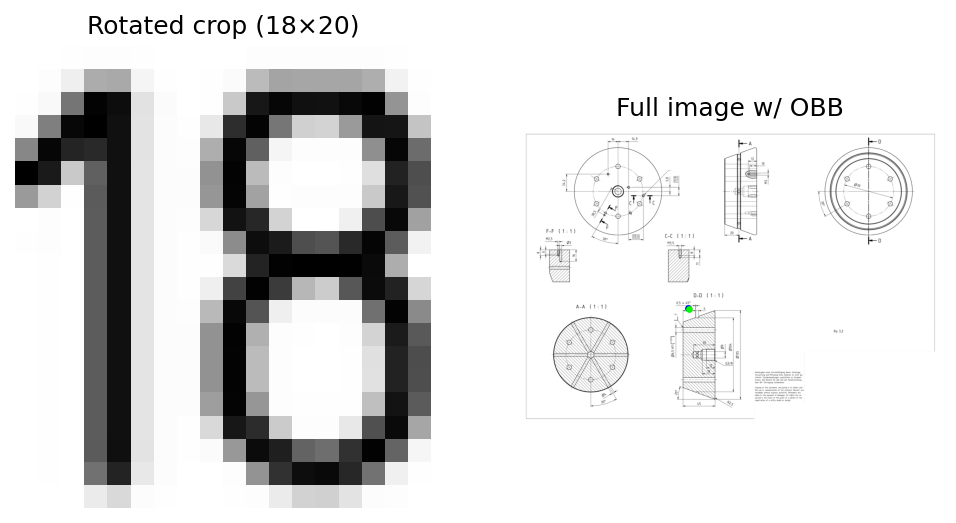


▶ Ann 101 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1287.6, 1988.8, 24.7, 19.2]


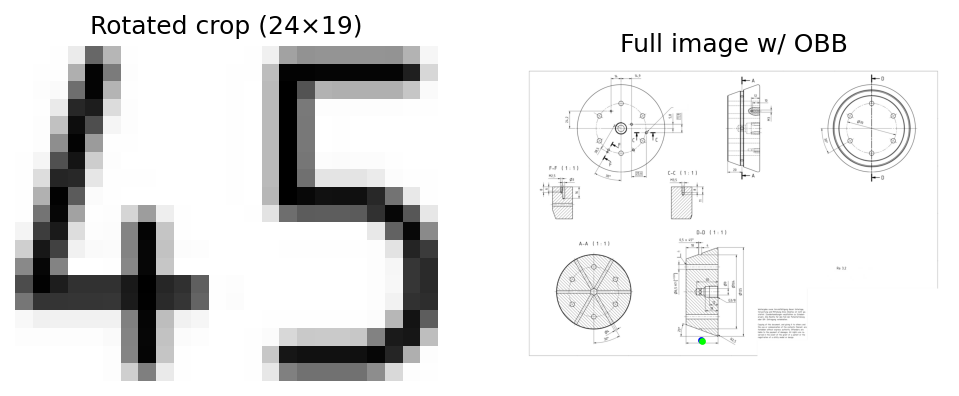


▶ Ann 102 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1676.3, 220.2, 19.4, 18.8]


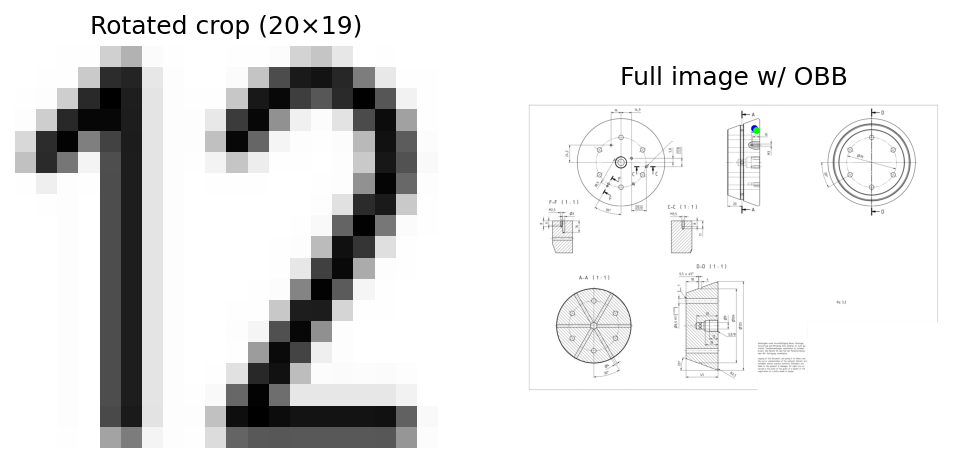


▶ Ann 103 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1525.59, 755.2, 22.21, 19.11]


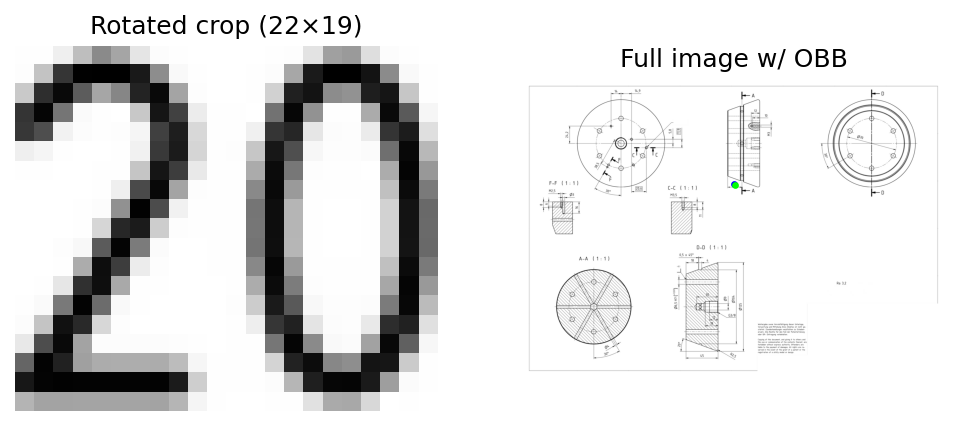


▶ Ann 104 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1327.0, 1548.1, 22.5, 18.5]


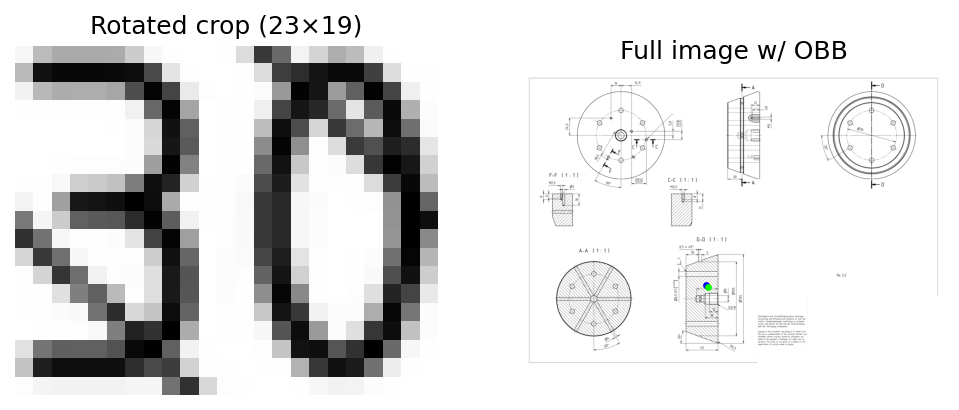


▶ Ann 105 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1262.4, 1200.0, 211.7, 33.0]


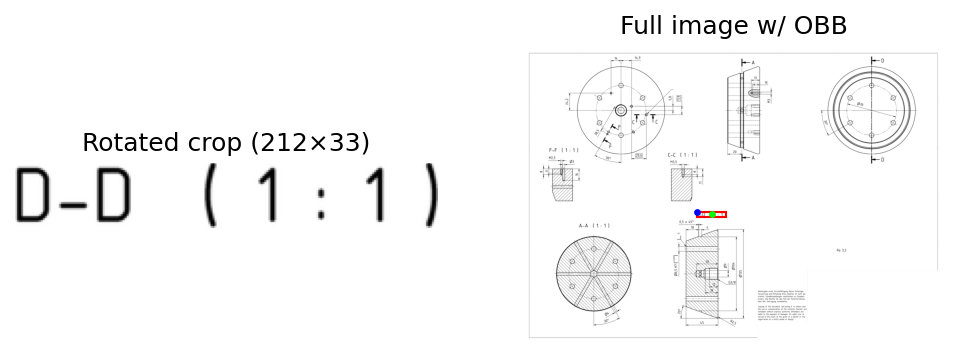


▶ Ann 107 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1333.9, 1300.8, 11.3, 18.5]


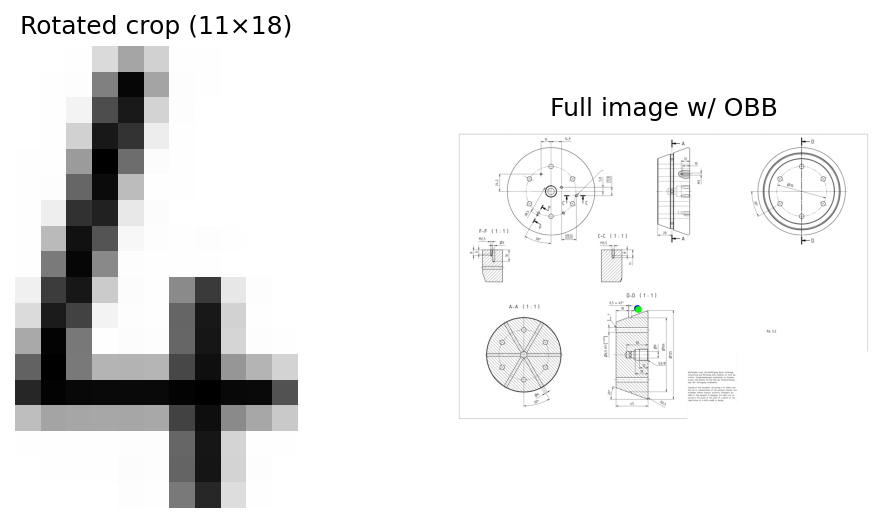


▶ Ann 108 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 0.0°
  bbox: [1118.5, 1347.9, 22.6, 13.3]


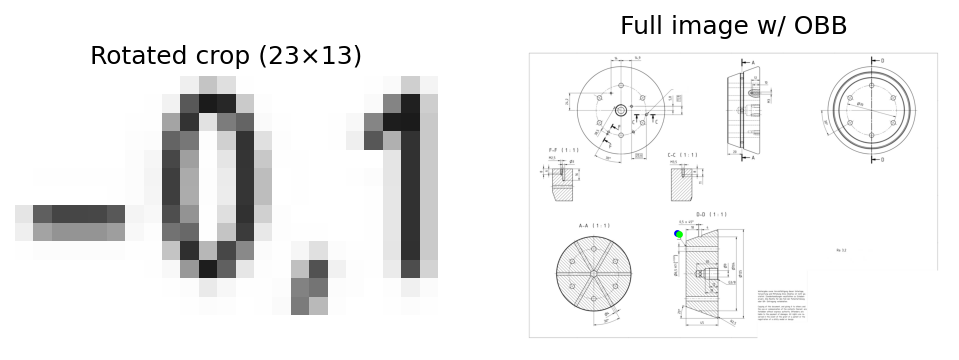

INFO:__main__:Ann 109: 90.0° → 0.0°



▶ Ann 109 on img 2 (7443.png)
  orig_rot: 90.0°, pred_rot: 0.0°
  bbox: [1242.3, 898.6, 10.55, 19.55]


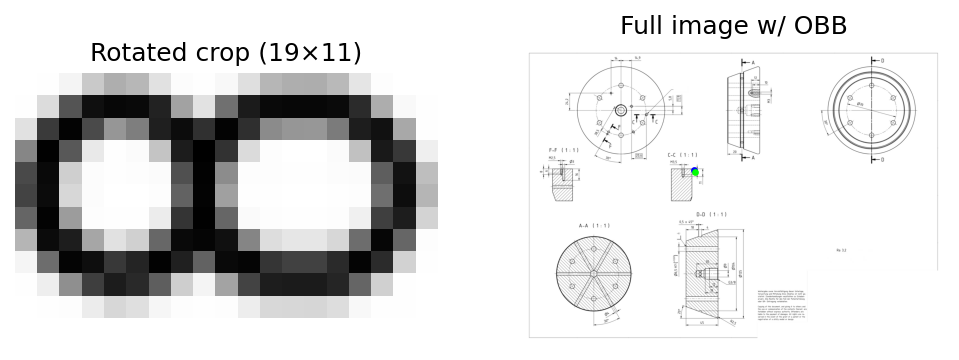

INFO:__main__:Ann 110: 270.0° → 0.0°



▶ Ann 110 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1280.55, 978.45, 15.2, 19.5]


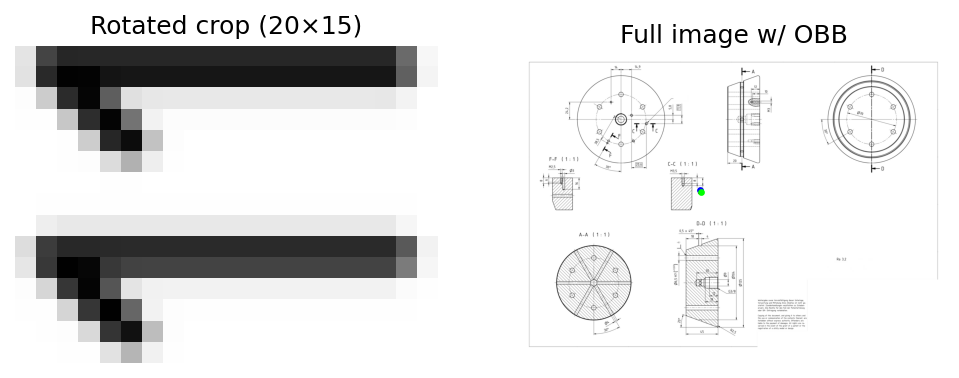

INFO:__main__:Writing COCO to ../data/rotation/batches/rotation_20250721_01/instances_predicted.json
INFO:__main__:Writing COCO to ../data/rotation/batches/rotation_20250721_01/instances_updated.json



=== Summary ===
 ann_id  img_id file_name                              bbox  orig_rot  pred_rot
     47       2  7443.png    [2596.23, 91.32, 16.97, 27.78]      0.00       0.0
     49       2  7443.png    [823.99, 780.24, 41.31, 22.46]      0.11       0.0
     50       2  7443.png    [412.5, 1280.62, 217.2, 33.28]      0.00       0.0
     51       2  7443.png      [385.15, 919.35, 19.0, 18.9]    270.00       0.0
     52       2  7443.png        [129.2, 903.2, 18.6, 10.4]      0.00       0.0
     53       2  7443.png      [170.95, 894.05, 10.2, 18.1]    270.00       0.0
     54       2  7443.png        [344.6, 821.8, 30.3, 26.4]      0.00       0.0
     56       2  7443.png        [195.6, 798.3, 44.9, 22.0]      0.00       0.0
     57       2  7443.png   [199.07, 734.95, 206.06, 33.25]      0.53       0.0
     58       2  7443.png    [303.14, 391.29, 43.47, 22.53]    270.10       0.0
     59       2  7443.png   [1118.98, 1908.26, 33.23, 19.0]    278.50       0.0
     60       2  7443.p

In [ ]:

# ---------------------------
# MAIN UPDATE
# ---------------------------
def update_rotations(target_image_id: int = 1, debug: bool = False):
    coco = load_coco(COCO_JSON)
    coco_pred = deepcopy(coco)  # will be saved with 4-tuple bbox
    coco_attr = deepcopy(coco)  # will be saved with updated attributes only
    model = load_model(CHECKPOINT_PATH)

    images = {img["id"]: img for img in coco["images"]}
    cache = {}
    records = []

    for ann, ann_pred, ann_attr in zip(coco["annotations"],
                                       coco_pred["annotations"],
                                       coco_attr["annotations"]):
        if ann["image_id"] != target_image_id:
            continue

        # Convert all to 5-tuple: [cx, cy, w, h, rotation]
        x, y, w, h = ann["bbox"][:4]
        orig_rot = extract_current_rotation(ann)
        cx, cy = x + w / 2, y + h / 2

        # Modify original annotation (used for prediction and visualization)
        ann["bbox"] = [cx, cy, w, h, orig_rot]

        # Only correct if rotation is within ±10° of base classes
        if not any(abs(orig_rot - base) <= 3 for base in CLASS_NAMES):
            continue

        info = images[ann["image_id"]]
        fname = info["file_name"]
        if fname not in cache:
            img = cv2.imread(str(IMAGES_DIR / fname))
            if img is None:
                logger.error(f"Cannot load {fname}")
                continue
            cache[fname] = img
        full_img = cache[fname]

        patch = (crop_rotated_preserve(full_img, cx, cy, w, h, orig_rot)
                 if orig_rot != 0 else crop_box(full_img, x, y, w, h))

        pred_rot = predict_angle(model, patch)

        records.append({
            "ann_id": ann["id"],
            "img_id": ann["image_id"],
            "file_name": fname,
            "bbox": [x, y, w, h],
            "orig_rot": orig_rot,
            "pred_rot": pred_rot
        })

        # Update ann_pred (saved as COCO)
        ann_pred["bbox"] = [x, y, w, h]  # 4-tuple format
        if pred_rot != orig_rot:
            logger.info(f"Ann {ann['id']}: {orig_rot}° → {pred_rot}°")
            ann_attr.setdefault("attributes", {})["rotation"] = pred_rot

        if debug:
            debug_annotation(ann["id"], ann["image_id"],
                             fname, orig_rot, pred_rot,
                             [x, y, w, h], full_img)

    # Save outputs
    save_coco(coco_pred, PRED_JSON)
    save_coco(coco_attr, ATTR_JSON)

    df = pd.DataFrame(records)
    print("\n=== Summary ===")
    print(df.to_string(index=False))


if __name__ == "__main__":
    update_rotations(target_image_id=2, debug=True)


In [11]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from pathlib import Path
import pandas as pd

def show_image_with_annotations_from_coco(coco_json_path: Path,
                                          images_dir: Path,
                                          image_filename: str,
                                          show_centres: bool = True,
                                          centre_color: str = "lime") -> None:
    """
    Display one COCO image with all rotated bounding boxes from a COCO-style JSON.
    """

    # Load COCO data
    with open(coco_json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    # Get image_id from image filename
    image_entry = next((img for img in coco["images"] if img["file_name"] == image_filename), None)
    if not image_entry:
        print(f"Image {image_filename} not found in COCO JSON.")
        return

    image_id = image_entry["id"]
    img_path = images_dir / image_filename

    if not img_path.exists():
        print("Image not found on disk:", img_path)
        return

    # Load image
    img = plt.imread(img_path)
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
    ax.imshow(img, aspect="equal")
    ax.set_title(f'{image_filename} (image_id={image_id})')
    ax.axis("off")

    # Get annotations for this image
    annotations = [ann for ann in coco["annotations"] if ann["image_id"] == image_id]

    if not annotations:
        print(f"No annotations found for image_id={image_id}")
        return

    for ann in annotations:
        x, y, w, h = ann["bbox"][:4]
        
        # Get rotation
        if len(ann["bbox"]) == 5:
            rotation = ann["bbox"][4]
        else:
            rotation = ann.get("attributes", {}).get("rotation", 0.0)

        # Draw rotated rectangle
        cx, cy = x + w / 2, y + h / 2
        rect = Rectangle((cx - w / 2, cy - h / 2), w, h,
                         linewidth=0.3, edgecolor="red", fill=False)
        transf = Affine2D().rotate_deg_around(cx, cy, rotation) + ax.transData
        rect.set_transform(transf)
        ax.add_patch(rect)
        ax.text(cx, cy, f'{rotation:.1f}°', color='green', fontsize=8, ha='right', va='top')

        if show_centres:
            ax.scatter(cx, cy, color=centre_color, s=1, zorder=1)

    plt.show()


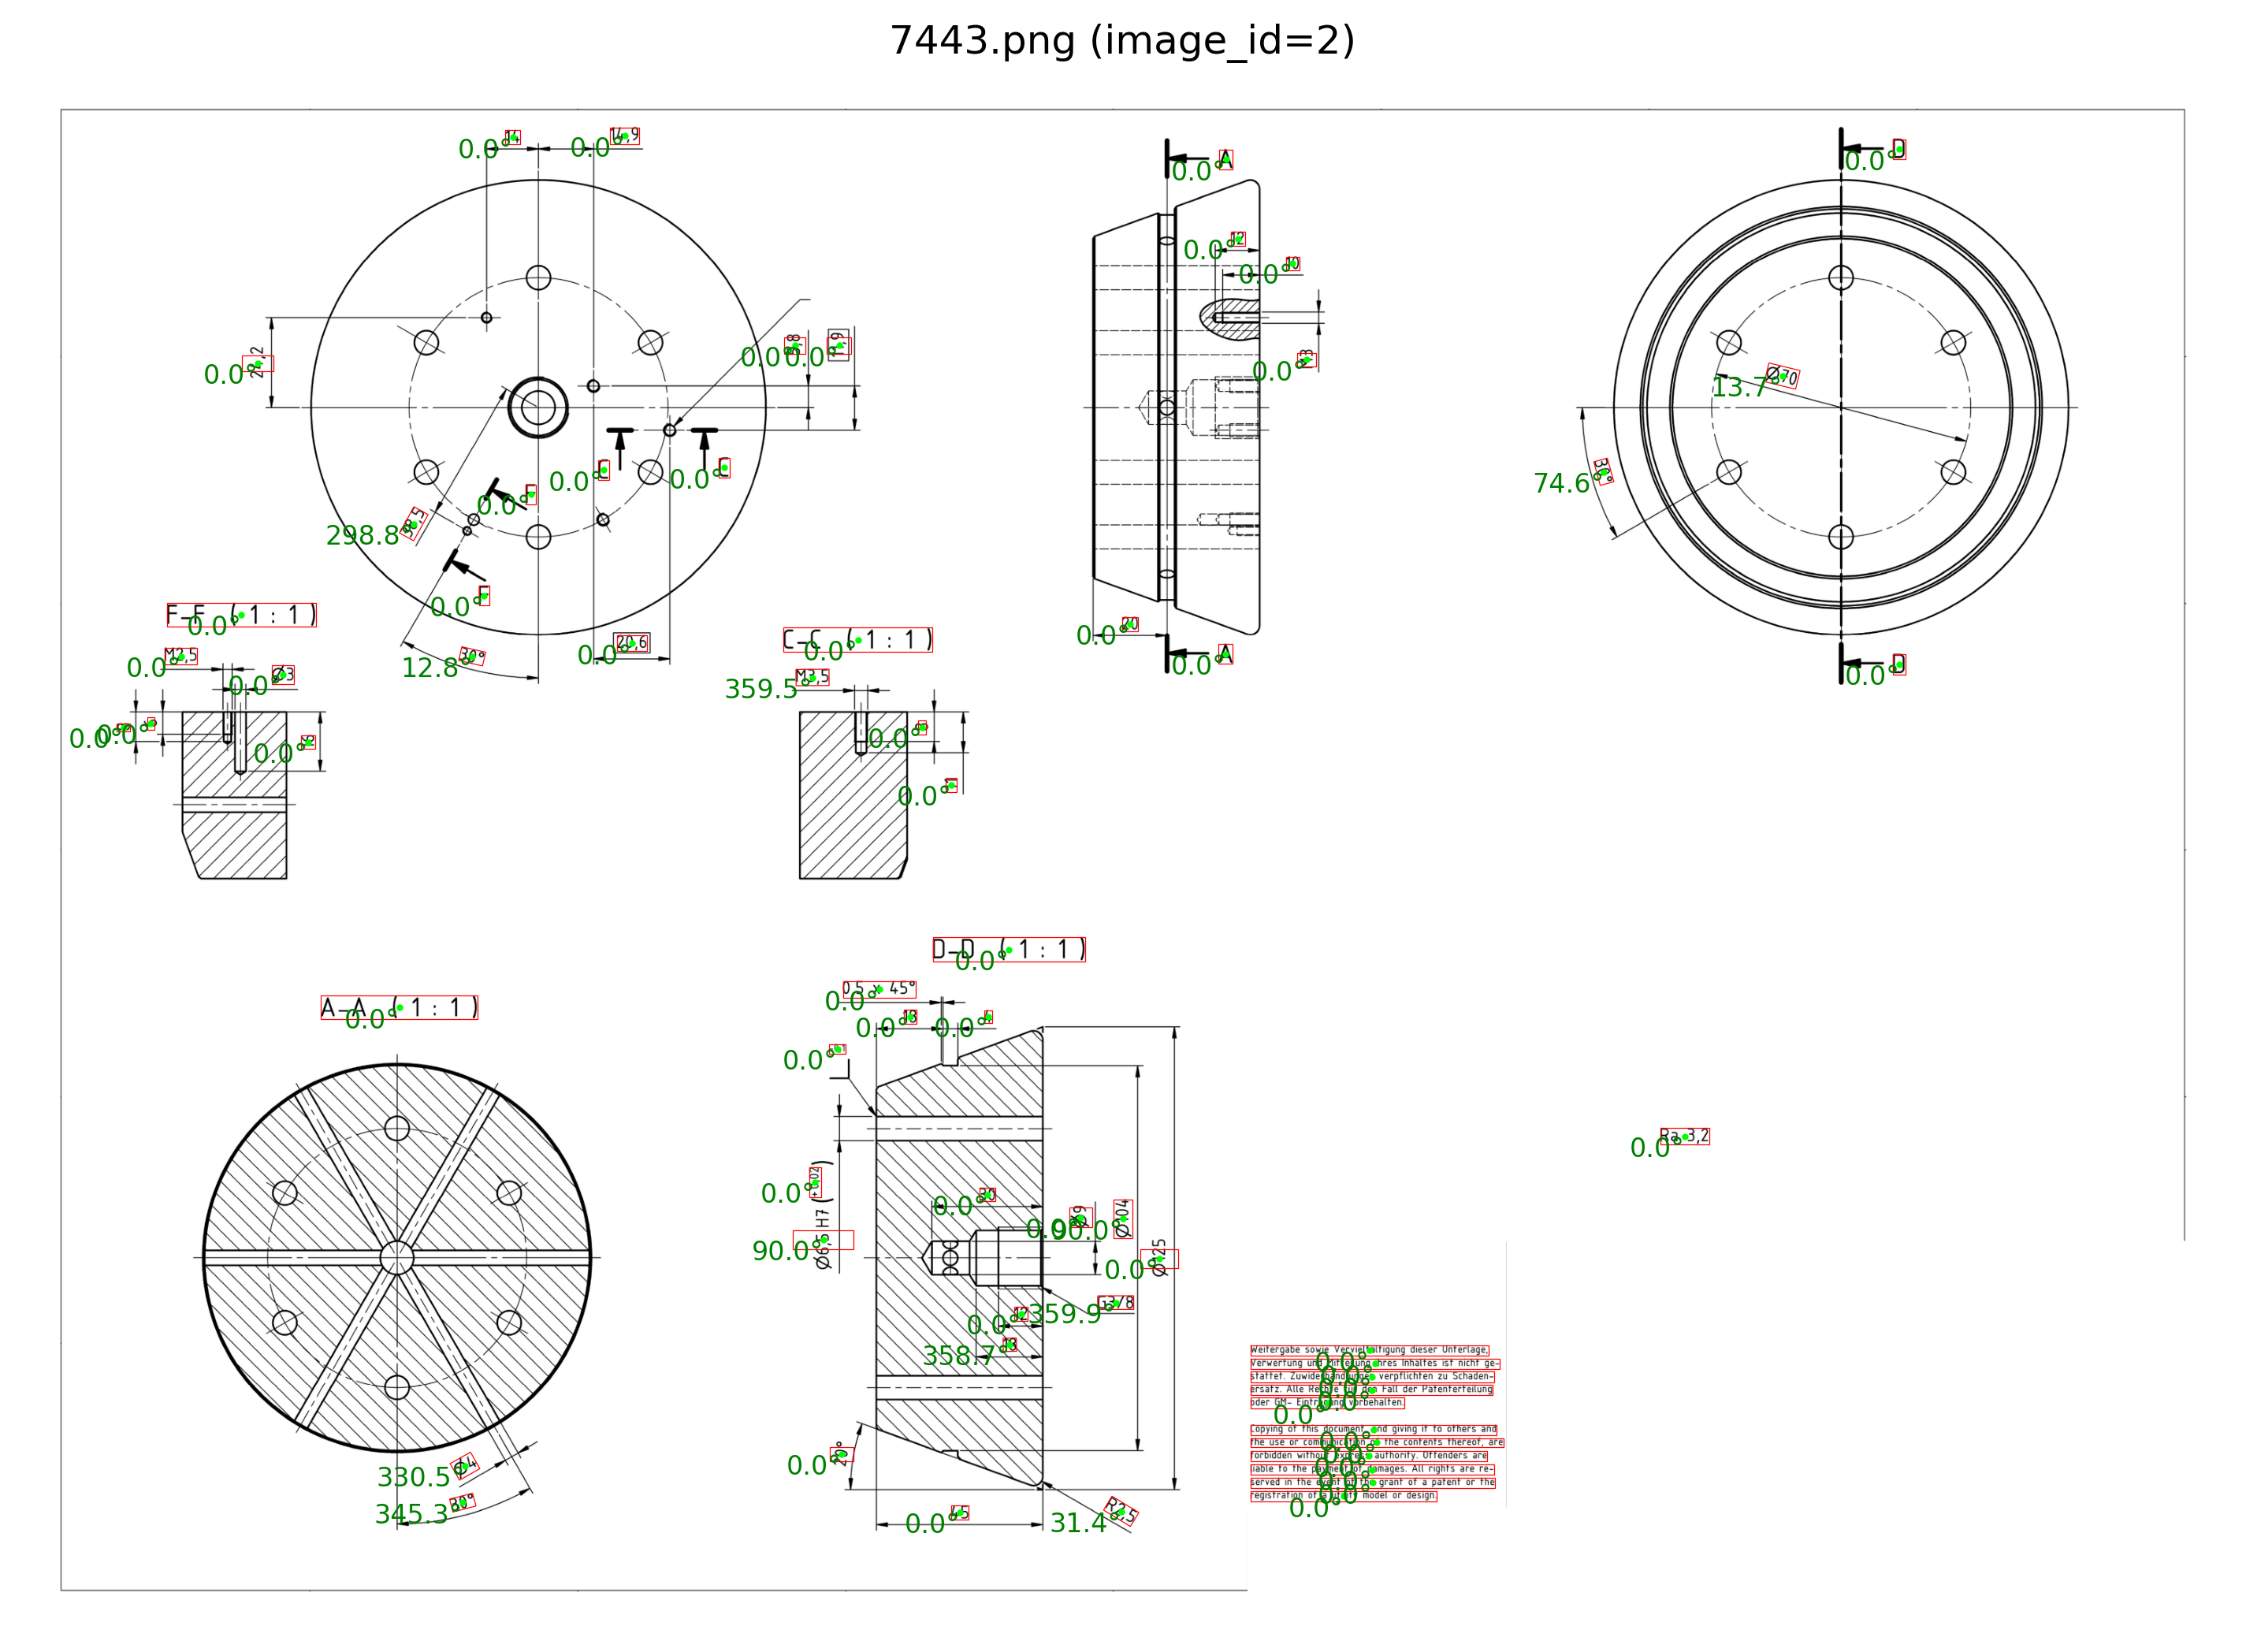

In [29]:
show_image_with_annotations_from_coco(
    coco_json_path=Path("../data/rotation/batches/rotation_20250721_01/instances_updated.json"),
    images_dir=Path("../data/rotation/batches/rotation_20250721_01/images/default"),
    image_filename="7443.png"
)


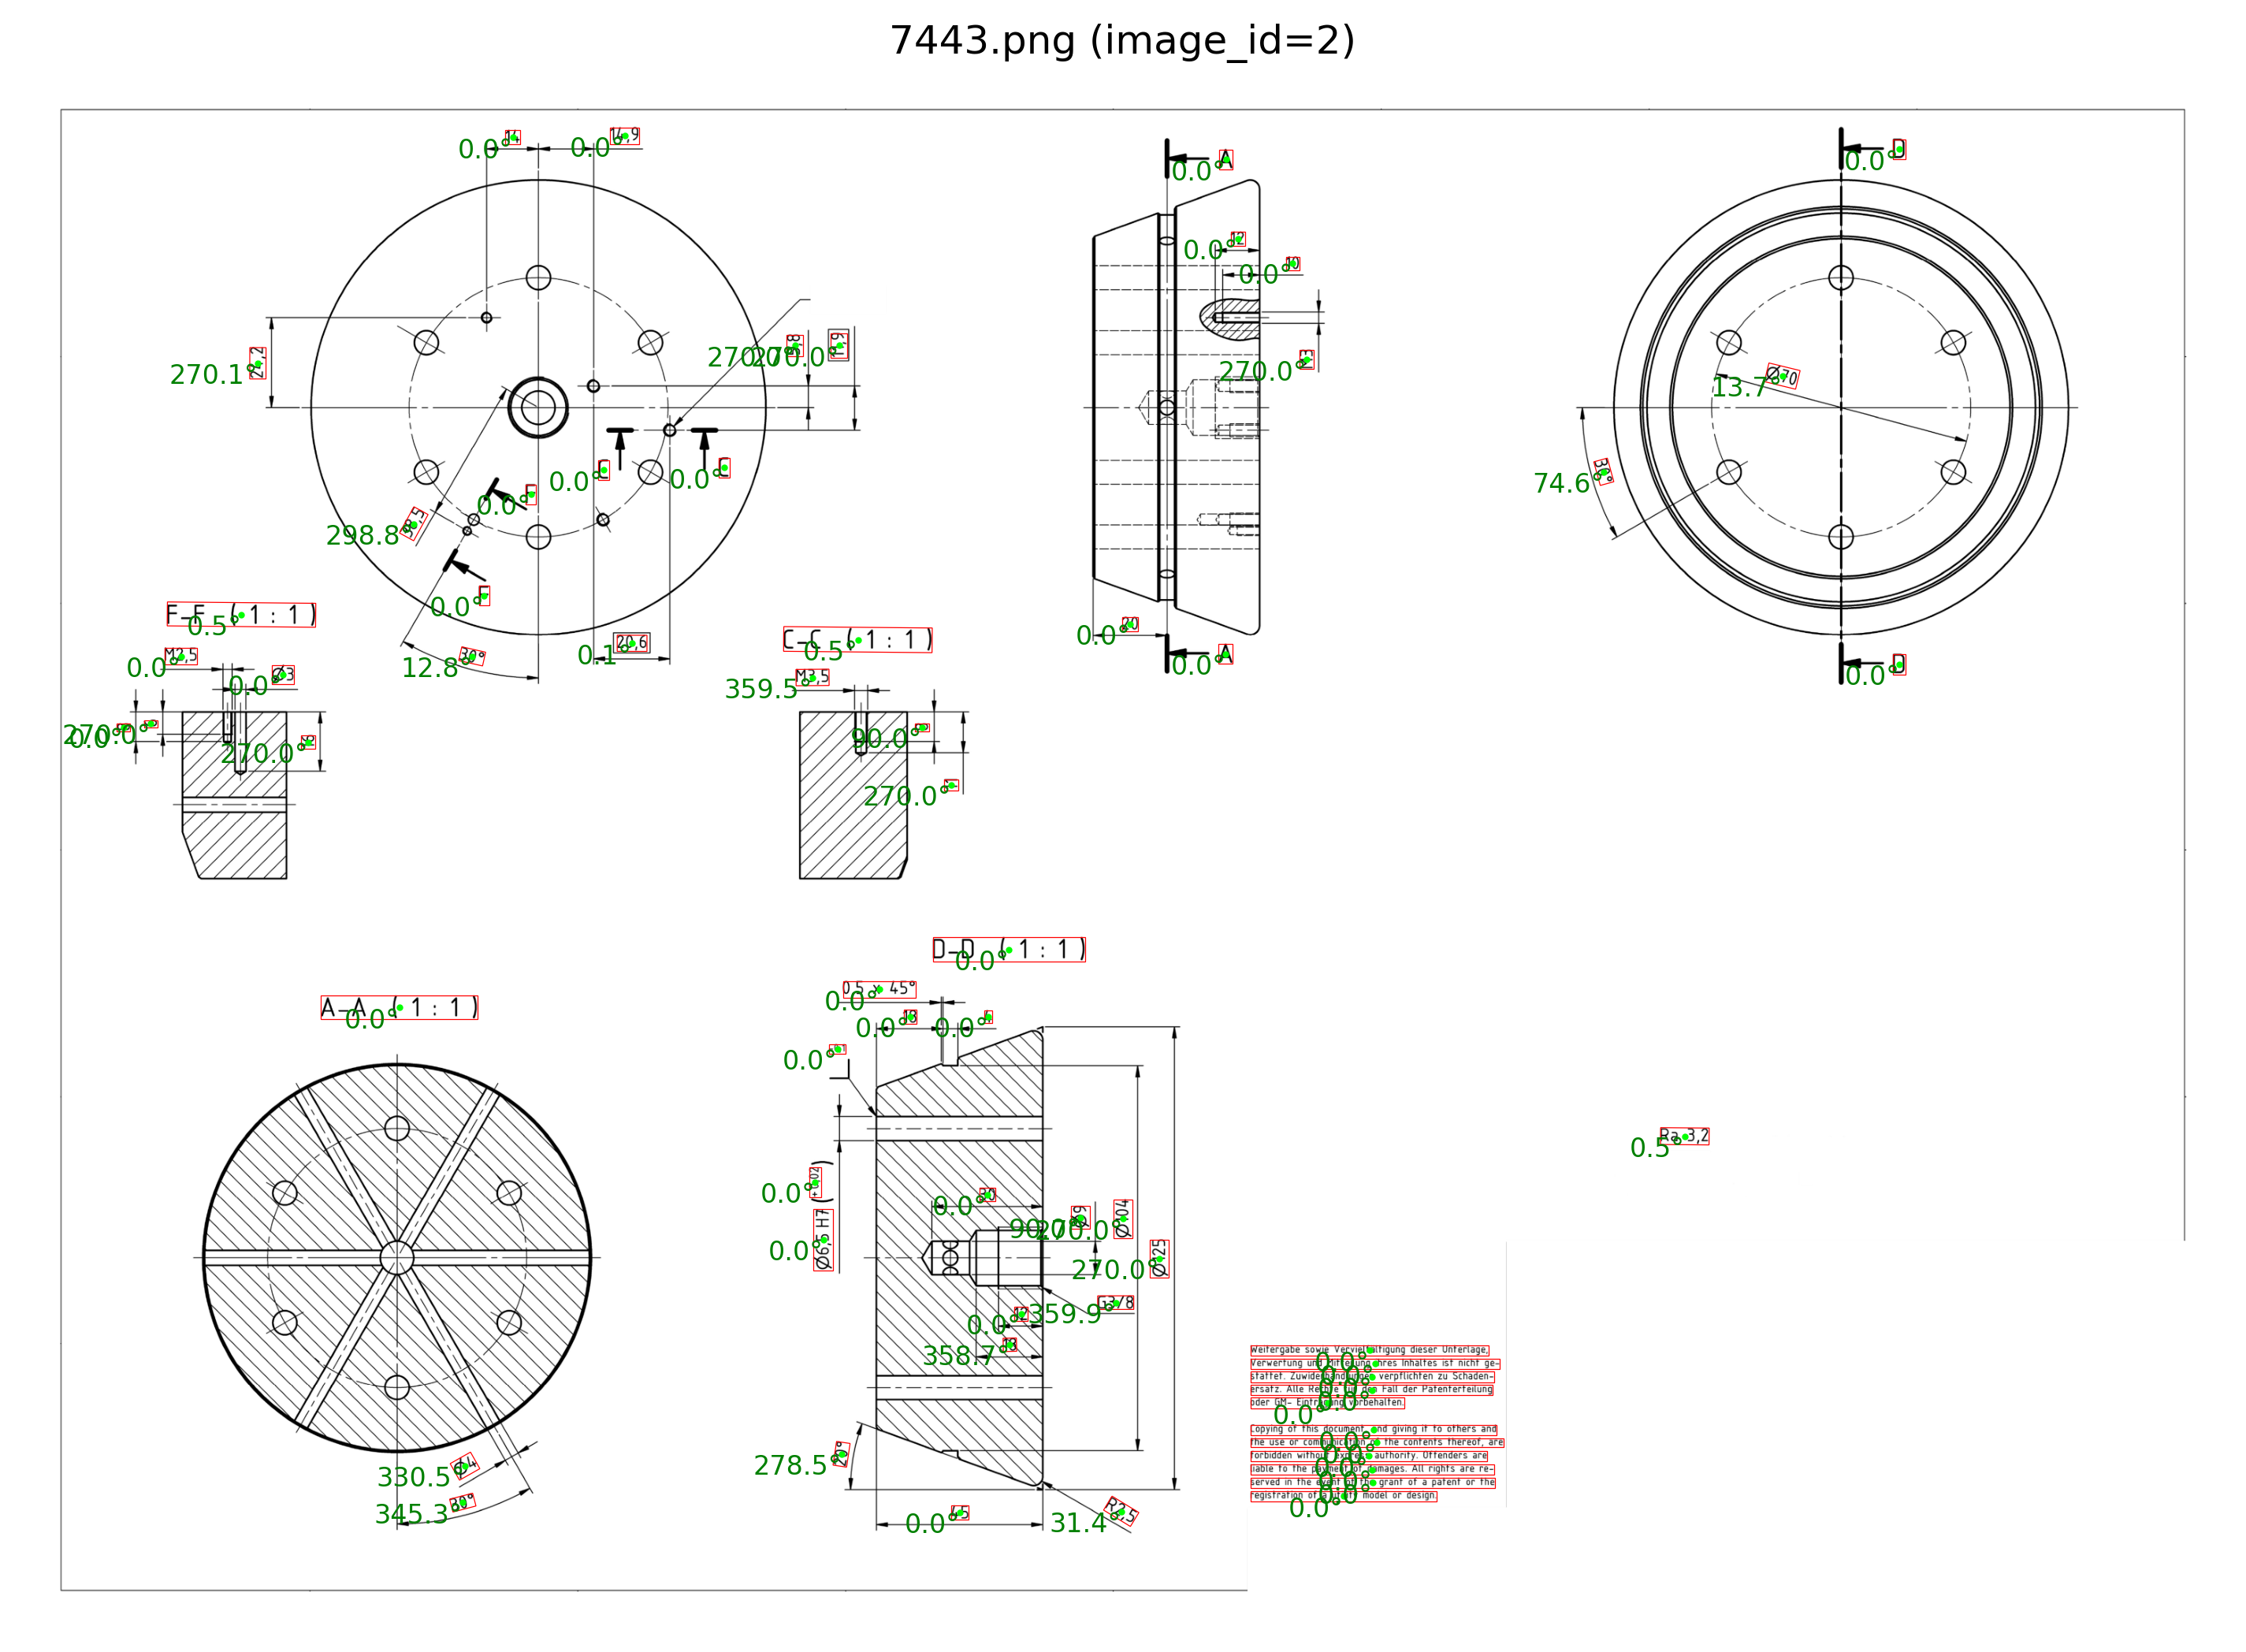

In [30]:
show_image_with_annotations_from_coco(
    coco_json_path=Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json"),
    images_dir=Path("../data/rotation/batches/rotation_20250721_01/images/default"),
    image_filename="7443.png"
)
